In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, precision_score, classification_report, RocCurveDisplay, auc, roc_curve

from imblearn.under_sampling import RandomUnderSampler

# Prevendo o salário com dados do censo

Este dataset do censo de 1994 dos Estados Unidos foi disponibilizado no *UCI Machine Learning Repository*. O objetivo é tentar classificar se uma pessoa recebe mais de $ 50.000,00 por ano. Este é um problema de classificação e como sabemos a saída esperada (> 50k/ano ou < 50k/ano) temos um problema de aprendizado supervisionado.

 O arquivo census_1994.csv contem o censo de 1994 com um total de **31.978 indivíduos** e possui as seguintes variáveis:

* age: a idade em anos
* workclass: classificação do tipo de trabalho da pessoa (exemplo: trabalha pro governo federal, trabalha pro governo federal, trabalha sem remuneração, etc).
* education: o nível de educação (exemplos: high school, 5th-6th grade, PhD, etc)
* maritalstatus: o estado civil da pessoa.
* occupation: o tipo de trabalho (ex.: administrativo, vendas, etc)
* relationship: relacionamento do indivíduo com os membros da sua família
* race: raça da pessoa
* sex: sexo da pessoa
* capitalgain: o ganho de capital de pessoa em 1994 (por vender alguma propriedade)
* capitalloss: o prejuízo de capital de uma pessoa 
* hoursperweek: número de horas trabalhadas por semana
* nativecountry: o país de nascimento
* over50k: se o indivíduo ganhou mais de $50.000,00 em 1994



## objetivo

Criar um modelo de arvore de decisão, utilizando *Cross-Validation* para tunar os hiperparâmetros e aumentar sua precisão.

## Analise

In [63]:
dados2 = pd.read_csv('https://raw.githubusercontent.com/abnr/ml-data/main/census.csv')
dados2.head()

,age,workclass,education,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,over50k
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [64]:
# dummyzando a coluna "over50k"

In [65]:
over50k = [0 if i == " <=50K" else 1 for i in dados2["over50k"]]
dados2["over50k"] = over50k
dados2["over50k"].unique()

array([0, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


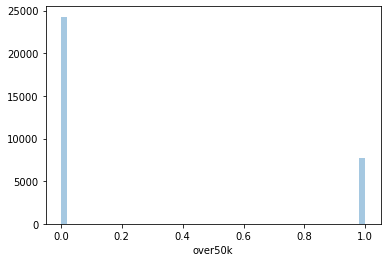

In [66]:
# plot da distribuição dos valores da coluna over50k
sns.distplot(dados2["over50k"], hist=True, kde=False, rug=False )

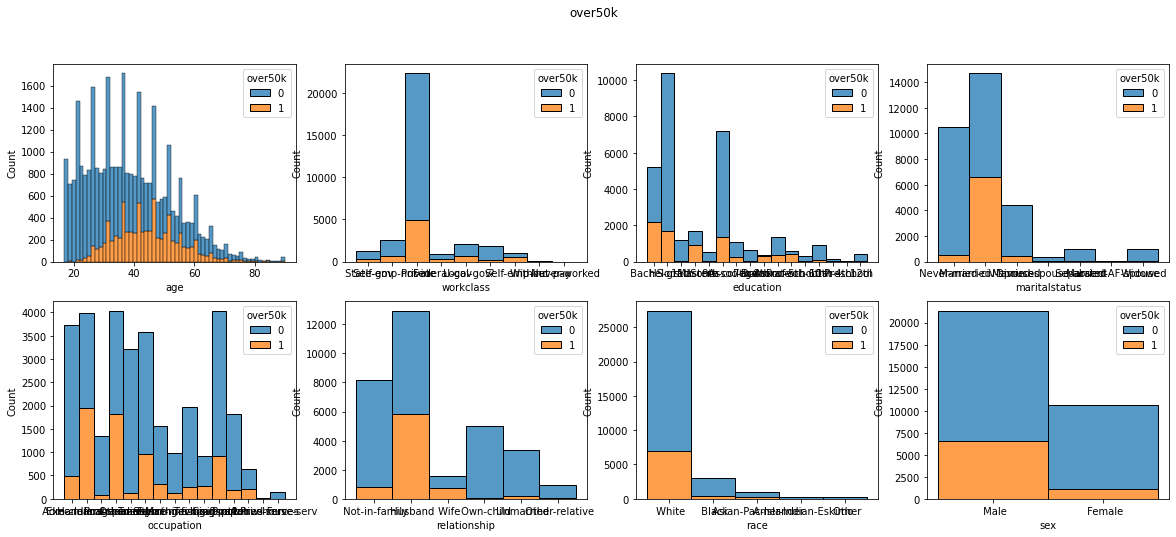

In [67]:
cols = dados2.columns
fig, axes = plt.subplots(2,4, figsize=(20,8), sharey= False)

fig.suptitle("over50k")

count = 0
for row in range(0,2):
  for col in range(0,4):
    sns.histplot(ax=axes[row,col], data = dados2, x=cols[count], hue="over50k", multiple = "stack")
    count += 1

In [68]:
# Juntar ocupation < 1000  Protective-serv | Priv-house-serv | Armed-Forces
dados2["occupation"].value_counts()

 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 ?                    1816
 Transport-moving     1572
 Handlers-cleaners    1350
 Farming-fishing       989
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64

In [69]:
dados2["occupation"].replace({" Protective-serv":" ?"," Priv-house-serv":" ?"," Armed-Forces":" ?"," Farming-fishing":" ?"," Tech-support":" ?"},inplace = True)

In [70]:
dados2["education"].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [71]:
dados2["education"].replace([" 9th"," 5th-6th"," 7th-8th"," 10th"," 11th"," 1st-4th"," 12th"," Preschool"],["didint finish School"]*8,inplace = True)
dados2["education"].replace([" HS-grad"," Prof-school"," Assoc-acdm"," Assoc-voc"],["Finish School"]*4,inplace = True)
dados2["education"].replace([" Bachelors"," Some-college"],["College/Bachelors"]*2,inplace = True)

Como os paises estão muito desequilibrados, com 29170 observações somente nos estados unidos, vamos juntar todos os demais paises na categoria Other.

In [72]:
dados2["nativecountry"].value_counts()

 United-States                 29170
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 France                           29
 

In [73]:
# Juntar paises != US
for i in dados2["nativecountry"]:
  if i != " United-States":
    dados2["nativecountry"].replace([i],["Other"],inplace = True)

In [74]:
dados2["nativecountry"].unique()

array([' United-States', 'Other'], dtype=object)

Unindo as observações de raça Amer-Indian-Eskimo e Asian-Pac-Islander em Other.

In [75]:
dados2["race"].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

In [76]:
dados2["race"].replace({" Amer-Indian-Eskimo":" Other"," Asian-Pac-Islander":" Other",},inplace = True)

Unindo os grupos com poucas observaç~eos (Married-AF-spouse e Married-spouse-absent) em Other.
Unindo as observações divorced com Separated, pois ambas acabam sendo redundante

In [77]:
dados2["maritalstatus"].value_counts()

 Married-civ-spouse       14692
 Never-married            10488
 Divorced                  4394
 Separated                 1005
 Widowed                    979
 Married-spouse-absent      397
 Married-AF-spouse           23
Name: maritalstatus, dtype: int64

In [78]:
#Juntar Married-AF-spouse e Married-spouse-absent em other | Juntar divorced com separated
dados2["maritalstatus"].replace({" Married-AF-spouse":" Other"," Married-spouse-absent":" Other"},inplace = True)
dados2["maritalstatus"].replace({" Separated":" Divorced"},inplace = True)

Devido a grande faixa de valores em idade, escolhi unir os valores observados em grupos de 30 anos. terminando com as observações:


*   até 30 anos
*   31 até 60 anos
*   61 até 90 anos




In [79]:
# juntar age
dados2["age"].unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 34, 25, 43, 40,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 47, 46,
       36, 79, 27, 67, 18, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58,
       26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82,
       83, 84, 85, 86, 87])

In [80]:
dados2["age"].replace({range(0,31):"até 30 anos",range(31,61):"31 até 60",range(61,91):"61 até 90"},inplace=True)

In [81]:
dados2["workclass"].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 ?                    1809
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [82]:
dados2["workclass"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

Apos analisar as variáveis "relationship" e "workclass" e seu impacto sobre o modelo, optei por retira-las dos dados. A variável relationship pode causar problemas de multicorrelação com a variável "maritalstatus".
Em testes paralelos, posteriormente, ambas não se mostraram capazes de apresentar informações relevantes ao modelo

In [83]:
# drop relationship e workclass
dados2.drop(["relationship","workclass"],axis=1,inplace=True)

nosso dataframe final ficou desse jeito

In [84]:
dados2.head()

,age,education,maritalstatus,occupation,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,over50k
0,31 até 60,College/Bachelors,Never-married,Adm-clerical,White,Male,2174,0,40,United-States,0
1,31 até 60,College/Bachelors,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,United-States,0
2,31 até 60,Finish School,Divorced,Handlers-cleaners,White,Male,0,0,40,United-States,0
3,31 até 60,didint finish School,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,United-States,0
4,até 30 anos,College/Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,Other,0


## Dummyzação e união de colunas

Como a variável "education" possui valores categoricos ordinais, podemos manter todas as observações encontradas sob uma mesma coluna. Reduzindo a dimensionalidade do modelo.
Além do mais é mais lógico pensar que alguem mais graduado tenha um salário maior do que alguem sem estudos. Especialmente em 1994.

In [85]:
dados2["education"].replace({'didint finish School': 0, 'Finish School': 1,'College/Bachelors': 2, ' Masters': 3, ' Doctorate': 4},inplace = True)

In [86]:
dados2["education"].value_counts()

1    13348
2    12397
0     4169
3     1674
4      390
Name: education, dtype: int64

Uma ultima olhada na distribuição dos dados

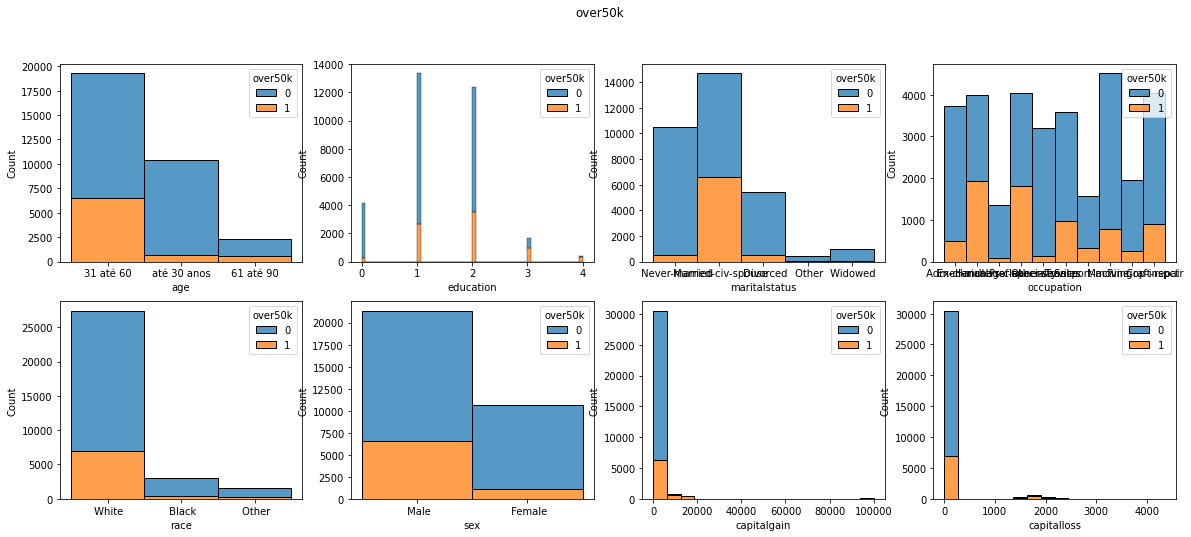

In [87]:
cols = dados2.columns
fig, axes = plt.subplots(2,4, figsize=(20,8), sharey= False)

fig.suptitle("over50k")

count = 0
for row in range(0,2):
  for col in range(0,4):
    sns.histplot(ax=axes[row,col], data = dados2, x=cols[count], hue="over50k", multiple = "stack")
    count += 1

In [88]:
ct = ColumnTransformer([ ("OHE",OneHotEncoder(sparse=False),['age', 'maritalstatus',
                                                             'occupation', 'race', 'sex', 'nativecountry','over50k'])],
                       remainder = "passthrough")

In [89]:
X = ct.fit_transform(dados2)

In [90]:
X = pd.DataFrame(X,columns=ct.get_feature_names_out())
X.head()

,OHE__age_31 até 60,OHE__age_61 até 90,OHE__age_até 30 anos,OHE__maritalstatus_ Divorced,OHE__maritalstatus_ Married-civ-spouse,OHE__maritalstatus_ Never-married,OHE__maritalstatus_ Other,OHE__maritalstatus_ Widowed,OHE__occupation_ ?,OHE__occupation_ Adm-clerical,...,OHE__sex_ Female,OHE__sex_ Male,OHE__nativecountry_ United-States,OHE__nativecountry_Other,OHE__over50k_0,OHE__over50k_1,remainder__education,remainder__capitalgain,remainder__capitalloss,remainder__hoursperweek
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,2.0,2174.0,0.0,40.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,13.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,40.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,40.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,40.0


In [91]:
y = X[["OHE__over50k_1"]]

#Dropando colunas target do X
X = X.drop(["OHE__over50k_1","OHE__over50k_0"],axis=1)

In [92]:
# Dropando colunas que somente aumentariam a dimensionalidade do modelo, sem trazer novas informações
# Por exemplo, sabemos que a coluna "sex" só possui dois valores: Male/Female. Logo se uma observação possui o valor 0 na coluna "Male", automaticamente ela DEVE ser "Female"
X = X.drop(["OHE__race_ Other","OHE__sex_ Female","OHE__nativecountry_Other"],axis=1)

In [93]:
X = X.convert_dtypes()
X.shape, y.shape

((31978, 26), (31978, 1))

In [94]:
X.head()

,OHE__age_31 até 60,OHE__age_61 até 90,OHE__age_até 30 anos,OHE__maritalstatus_ Divorced,OHE__maritalstatus_ Married-civ-spouse,OHE__maritalstatus_ Never-married,OHE__maritalstatus_ Other,OHE__maritalstatus_ Widowed,OHE__occupation_ ?,OHE__occupation_ Adm-clerical,...,OHE__occupation_ Sales,OHE__occupation_ Transport-moving,OHE__race_ Black,OHE__race_ White,OHE__sex_ Male,OHE__nativecountry_ United-States,remainder__education,remainder__capitalgain,remainder__capitalloss,remainder__hoursperweek
0,1,0,0,0,0,1,0,0,0,1,...,0,0,0,1,1,1,2,2174,0,40
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,1,2,0,0,13
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,40
3,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,40
4,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,2,0,0,40


In [95]:
y

,OHE__over50k_1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
31973,0.0
31974,1.0
31975,0.0
31976,0.0


## Fazendo o modelo

Como neste caso não vejo grandes vantagens de negócio em optar por alguma métrica de precisão específica, optei por usar o F-1 pois este funciona como

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [97]:
dt_teste = DecisionTreeClassifier(criterion='gini', max_depth = 5, min_samples_split= 20, ccp_alpha=0)
dt_teste.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_split=20)

In [98]:
dt_teste.predict(X_test)

array([0., 1., 1., ..., 0., 0., 0.])

In [59]:
#train
print("TRAIN","\n")
print( 'Recall', recall_score( y_train, dt_teste.predict(X_train) ) )
print( 'Accuracy', accuracy_score( y_train,  dt_teste.predict(X_train) ) )
print( 'Precision', precision_score( y_train,  dt_teste.predict(X_train) ) )
print( 'F1', f1_score( y_train,  dt_teste.predict(X_train) ) )

TRAIN 

Recall 1.0
Accuracy 1.0
Precision 1.0
F1 1.0


In [99]:
#Test
print("TEST","\n")
print( 'Recall', recall_score( y_test, dt_teste.predict(X_test) ) )
print( 'Accuracy', accuracy_score( y_test,  dt_teste.predict(X_test) ) )
print( 'Precision', precision_score( y_test,  dt_teste.predict(X_test) ) )
print( 'F1', f1_score( y_test,  dt_teste.predict(X_test) ) )

TEST 

Recall 0.5971997845988153
Accuracy 0.841400875547217
Precision 0.6807857581338245
F1 0.6362593230063109


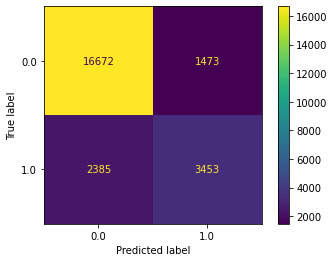

In [100]:
ConfusionMatrixDisplay.from_estimator(dt_teste, X_train, y_train)

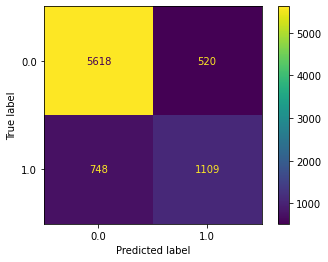

In [101]:
ConfusionMatrixDisplay.from_estimator(dt_teste, X_test, y_test)

## Under Sample
Vimos que o dataframe é muito desbalanceado e é extenso, com 31978 linhas, podemos realizar a tecnica de Under Sample que consiste em equilibra o dataframe retirando amostras da classe de mais peso nos dados.
Ao final reduzimos nosso dataframe para 15390 linhas. Porém com o mesmo numero de observações para cada classe, melhorando o desempenho do modelo.

In [103]:
dados2.groupby("over50k").count()

,age,education,maritalstatus,occupation,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry
over50k,,,,,,,,,,
0,24283,24283,24283,24283,24283,24283,24283,24283,24283,24283
1,7695,7695,7695,7695,7695,7695,7695,7695,7695,7695


In [104]:
rus = RandomUnderSampler(random_state=42, sampling_strategy="majority")
X_res, y_res = rus.fit_resample(X, y)

In [105]:
print(X_res.shape)
print(y_res.shape)

(15390, 26)
(15390, 1)


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res)

In [107]:
dt = DecisionTreeClassifier(criterion='gini', max_depth = 9, min_samples_split= 11, ccp_alpha=0, class_weight = "balanced")
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced', max_depth=9,
                       min_samples_split=11)

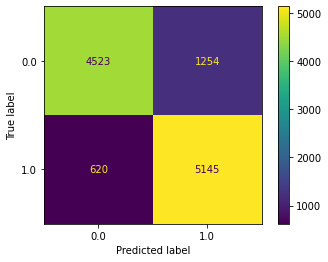

In [108]:
ConfusionMatrixDisplay.from_estimator(dt, X_train, y_train)

In [109]:
print("  TRAIN  ")
print( 'Recall', recall_score( y_train, dt.predict(X_train) ) )
print( 'Accuracy', accuracy_score( y_train,  dt.predict(X_train) ) )
print( 'Precision', precision_score( y_train,  dt.predict(X_train) ) )
print( 'F1', f1_score( y_train,  dt.predict(X_train) ) )

  TRAIN  
Recall 0.8924544666088465
Accuracy 0.8376364581528332
Precision 0.804031879981247
F1 0.8459388359092403


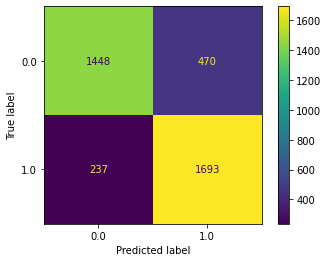

In [110]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

In [111]:
print("  TEST  ")
print( 'Accuracy', accuracy_score( y_test, dt.predict(X_test) ) )
print( 'Precision', precision_score( y_test, dt.predict(X_test)) )
print( 'Recall', recall_score( y_test, dt.predict(X_test) ) )
print( 'F1', f1_score( y_test,  dt.predict(X_test) ) )

  TEST  
Accuracy 0.8162681912681913
Precision 0.7827092001849283
Recall 0.8772020725388601
F1 0.8272660640117273


O balanceamento dos dados aumentou a precisão do nosso modelo em cerca de 20%.

## Usando o GridSearch para tunar o modelo

In [112]:
#botar gridsearch

dt = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = {
    'max_depth': list(range(1, 10)),
    "criterion":["gini", "entropy"],
    "min_samples_split":list(range(2,100)),
    "ccp_alpha":[0,0.1,0.2,0.3],
    "class_weight":["balanced",None]
}

In [113]:
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=skf, scoring='f1')

In [ ]:
# Essa linha esta comentada, pois esse GridSearchCV demorou cerca de 2h para rodar
# %%time
# grid.fit(X_train, y_train)

# grid.best_params_

Após a conclusão do GridSearchCV temos que os melhores  hiperparâmetros foram: criterion='gini', max_depth = 8, min_samples_split= 11, ccp_alpha=0, class_weight = "balanced"

In [114]:
dt = DecisionTreeClassifier(criterion='gini', max_depth = 8, min_samples_split= 11, ccp_alpha=0, class_weight = "balanced")
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced', max_depth=8,
                       min_samples_split=11)

# Análises finais
Ao final o modelo obteve um F1 score de 84% para o treino e 82% para o teste.
Consiguimos uma AUC de .89

In [115]:
print("  TRAIN  ")
print( 'Recall', recall_score( y_train, dt.predict(X_train) ) )
print( 'Accuracy', accuracy_score( y_train,  dt.predict(X_train) ) )
print( 'Precision', precision_score( y_train,  dt.predict(X_train) ) )
print( 'F1', f1_score( y_train,  dt.predict(X_train) ) )

  TRAIN  
Recall 0.8839549002601909
Accuracy 0.8323514122335817
Precision 0.8010059729644766
F1 0.8404386905252742


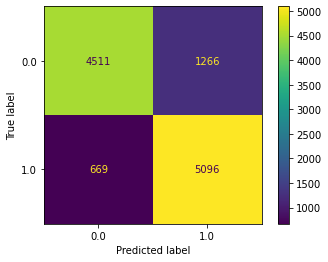

In [116]:
ConfusionMatrixDisplay.from_estimator(dt, X_train, y_train)

In [ ]:
print("  TEST  ")
print( 'Accuracy', accuracy_score( y_test, dt.predict(X_test) ) )
print( 'Precision', precision_score( y_test, dt.predict(X_test)) )
print( 'Recall', recall_score( y_test, dt.predict(X_test) ) )
print( 'F1', f1_score( y_test,  dt.predict(X_test) ) )

  TEST  
Accuracy 0.818087318087318
Precision 0.7942289498580889
Recall 0.8636831275720165
F1 0.8275012321340561


In [120]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81      1918
         1.0       0.79      0.87      0.83      1930

    accuracy                           0.82      3848
   macro avg       0.82      0.82      0.82      3848
weighted avg       0.82      0.82      0.82      3848



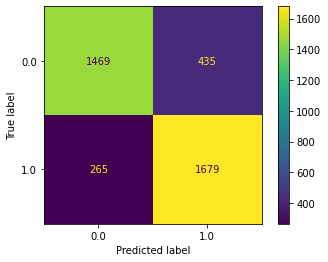

In [ ]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

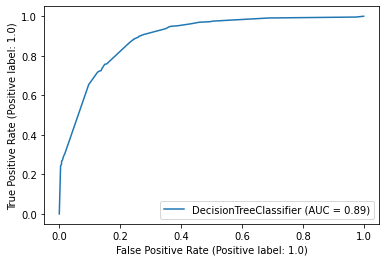

In [ ]:
RocCurveDisplay.from_estimator(dt, X_test, y_test)

Assim ficou o formato da arvore

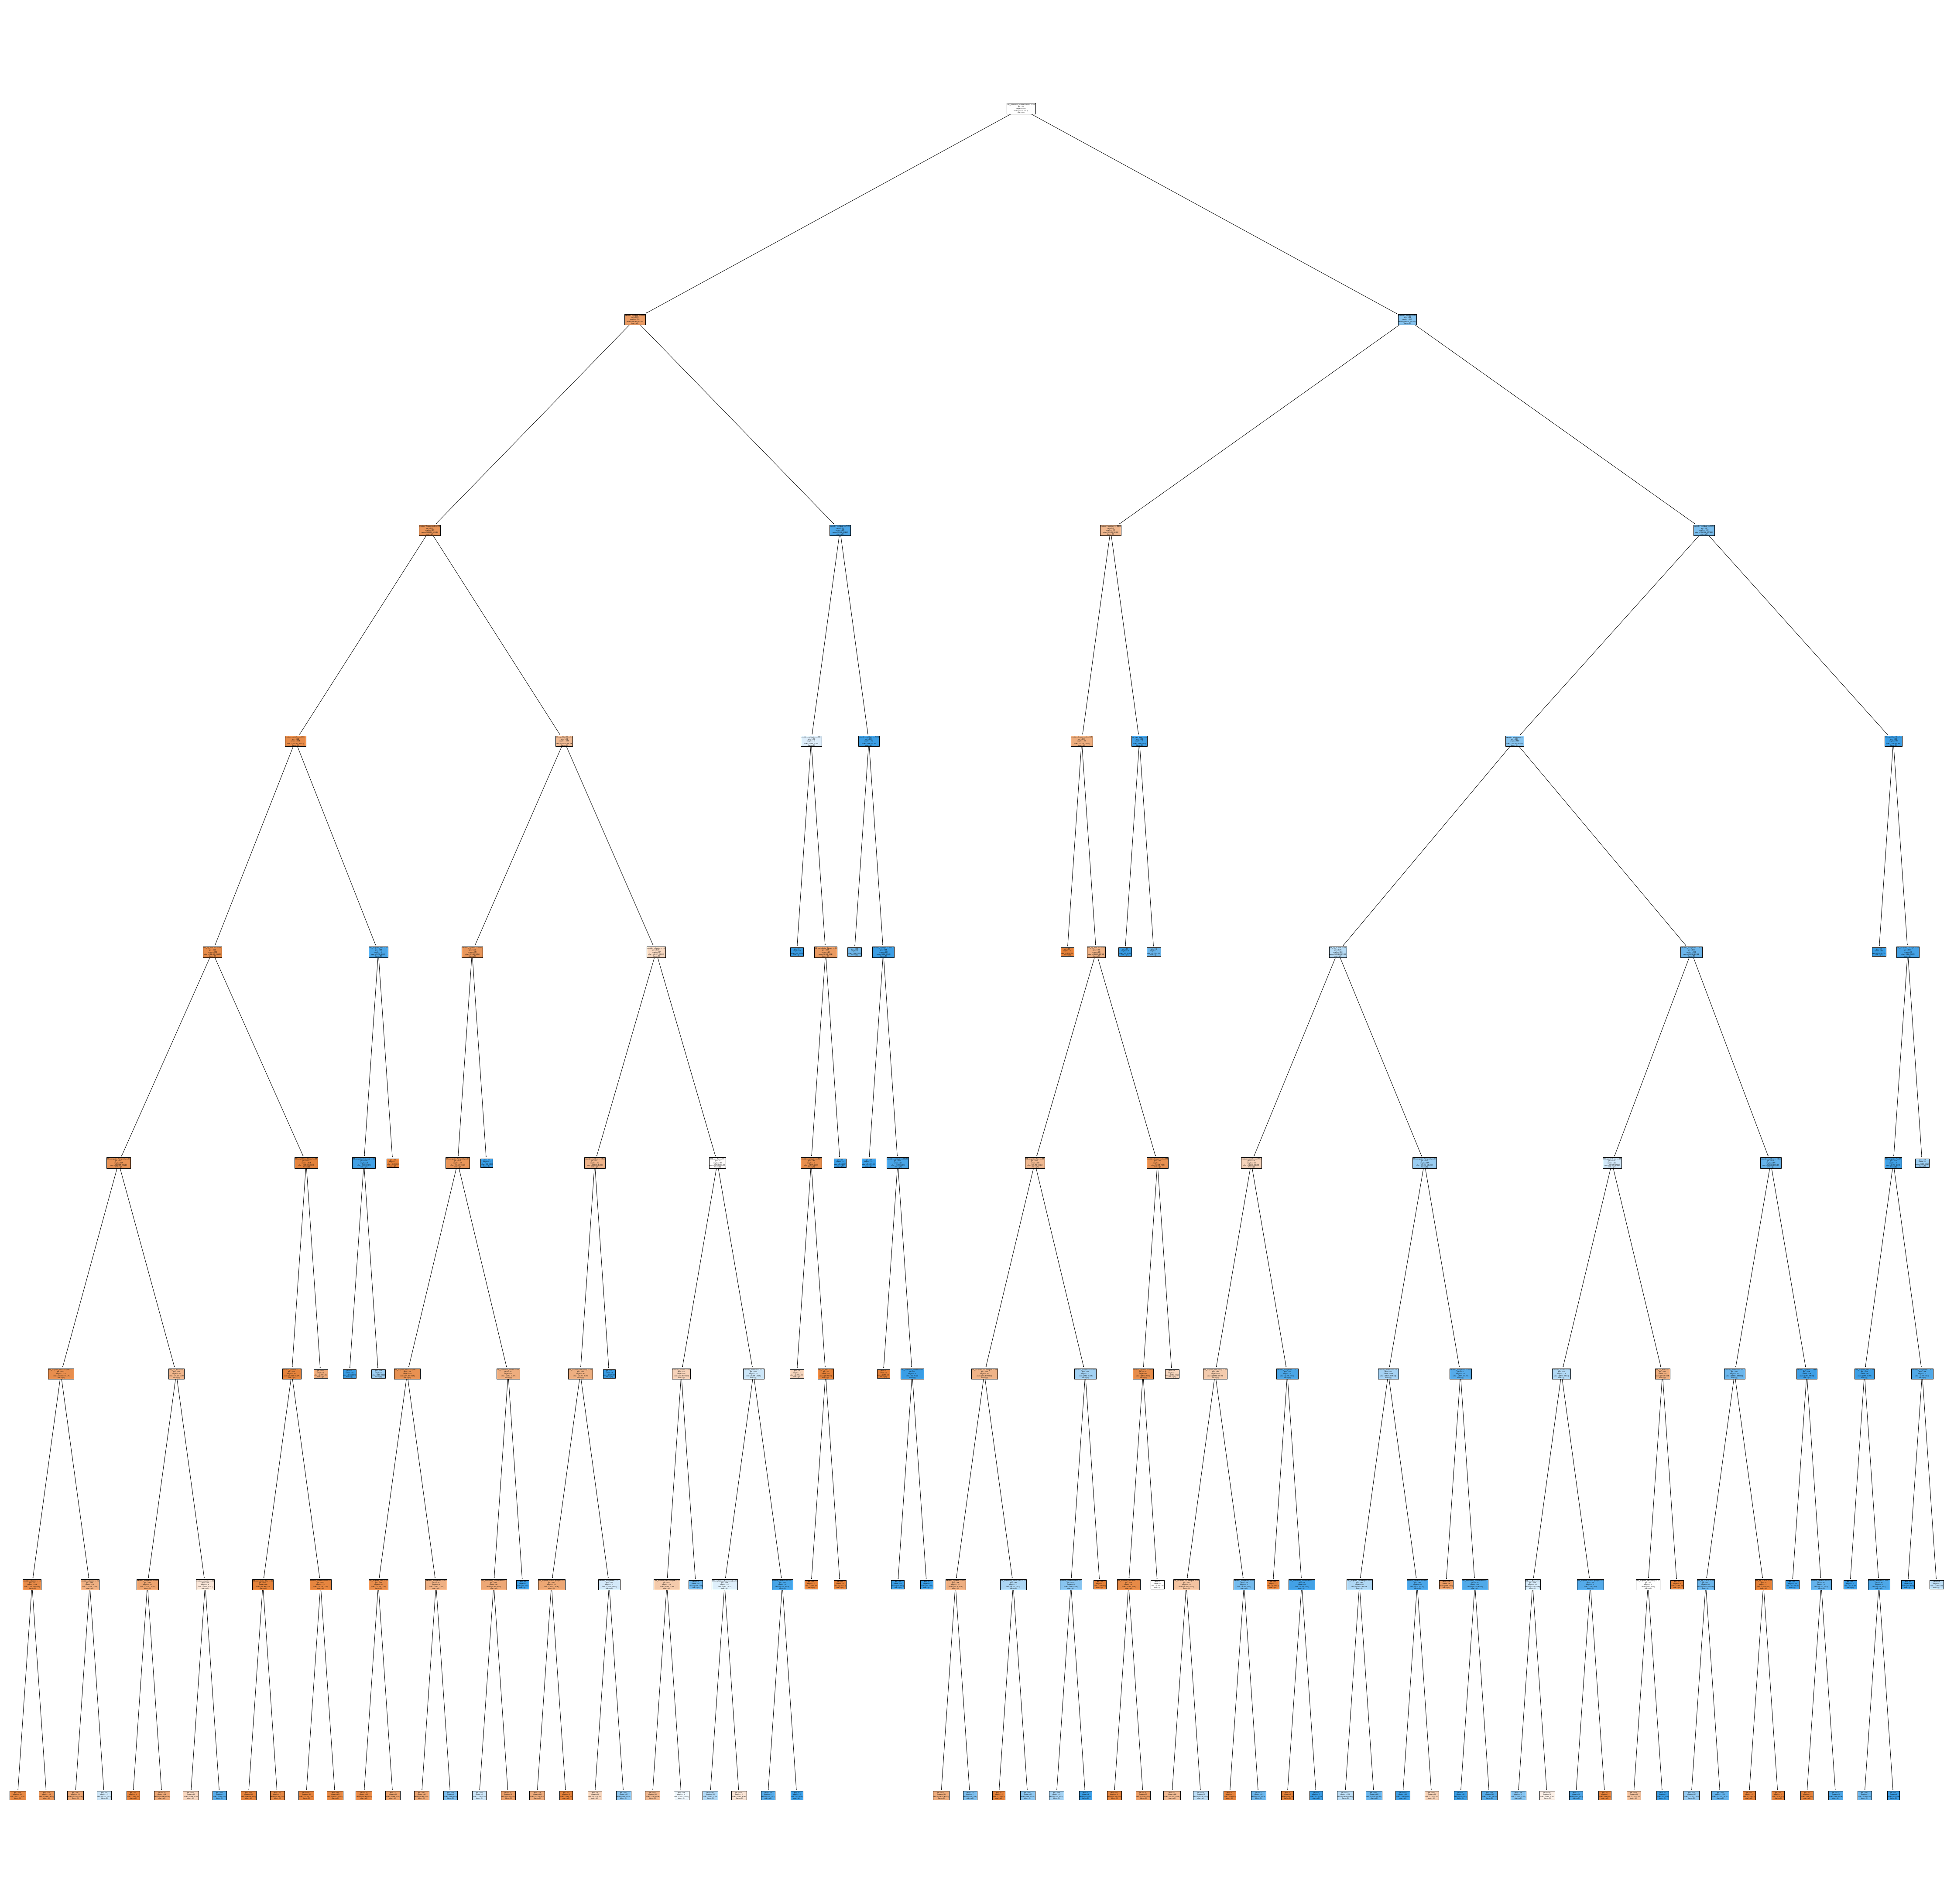

In [123]:
fig = plt.figure(figsize=(80,80))

plot_tree(dt, feature_names=X_train.columns, class_names= True, filled=True);